(18, 1625, 2521)
train_count_per_dataset: 200
points_per_class: 33
raster_points: ((509334.46249847836, 3796773.410956108), (534544.4624984784, 3796773.410956108), (534544.4624984784, 3780523.410956108), (509334.46249847836, 3780523.410956108))


Processing « Meadow »: 100%|██████████| 6/6 [00:06<00:00,  1.15s/it]     


Batch Shape
(200, 1, 1, 18)
Label Shape
(200, 10)
----
(100, 18)
Accuracy: 43.00%
Accuracy: 43.00%
Precision: 46.46%
Recall: 43.00%
F1 score: 42.72%
Done!


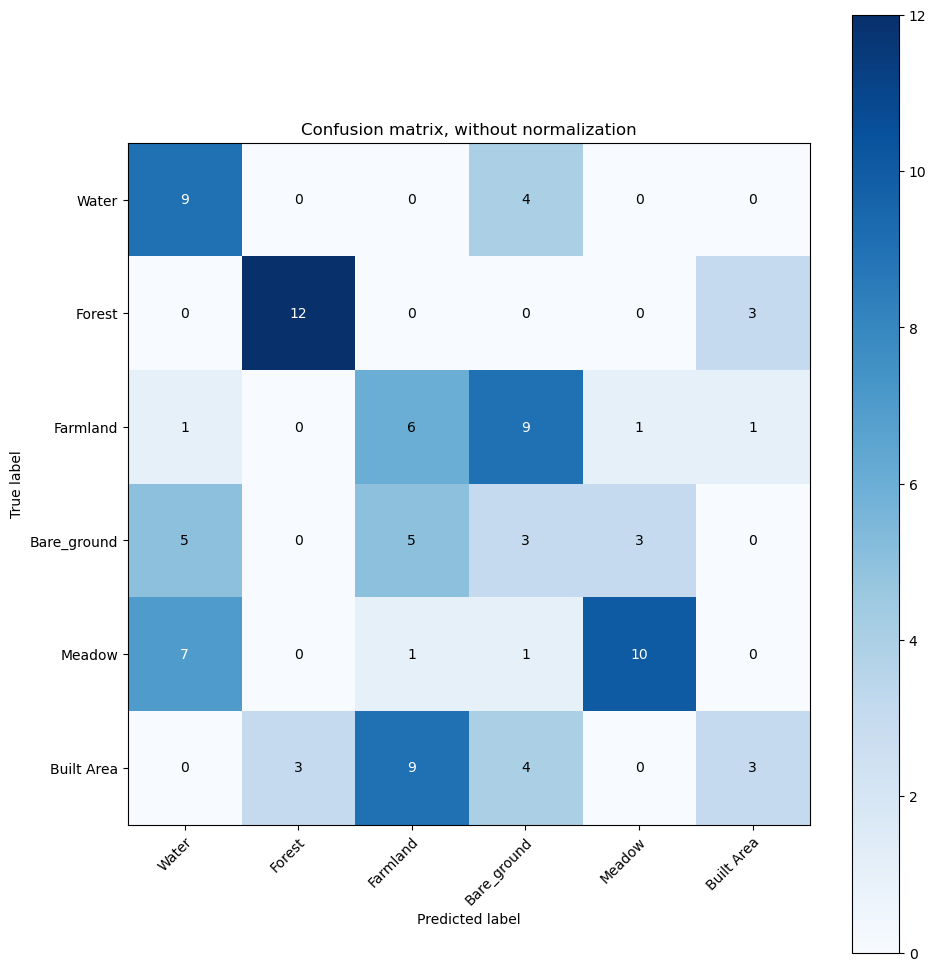

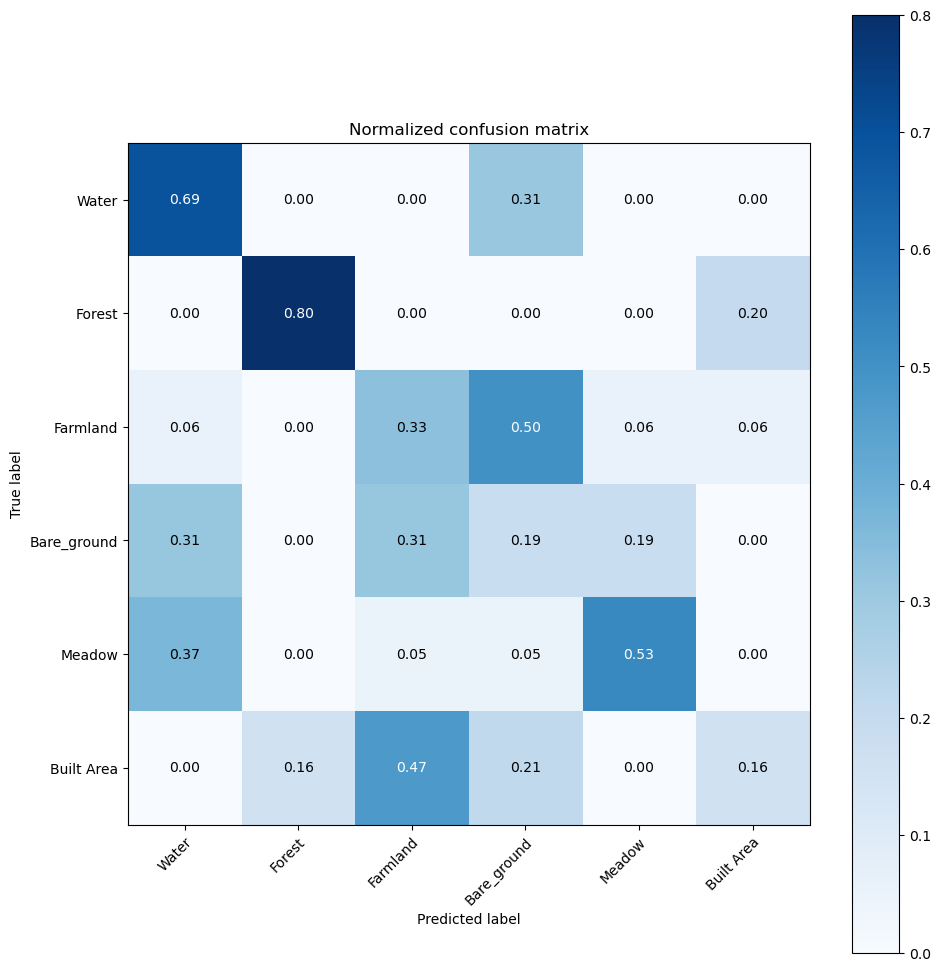

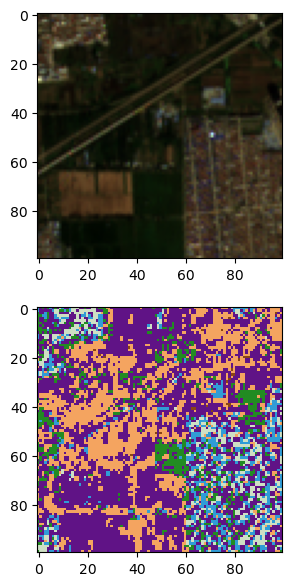

In [1]:
import rasterio
import matplotlib

import random
import math
import itertools

from rasterio.plot import adjust_band
import matplotlib.pyplot as plt
from rasterio.plot import reshape_as_raster, reshape_as_image
from rasterio.plot import show
from rasterio.windows import Window
import rasterio.features
import rasterio.warp
import rasterio.mask

import numpy as np

from pyproj import Proj, transform
from tqdm import tqdm
from shapely.geometry import Polygon

from sklearn import neighbors, datasets
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score

import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, BatchNormalization
from keras.callbacks import ModelCheckpoint

from functions import merge_classes
from functions import tile_generator
from functions import gen_balanced_pixel_locations
from functions import plot_confusion_matrix

from dict import class_names

# % matplotlib inline

# change to sentinel_path
sentinel_path = 'D:/DATA/LULC/01_Prepare/Sentinel2/06_test_dataset/test_S2A_MSIL2A_20210921T025551_N9999_R032_T50_20221119T225446_super_resolved_mosaic_stack_DEM_slope_collocation.tif'

# change to graoung_truth_path
labels_path = 'D:/DATA/LULC/02_Training/01_test/clip_test_ground_truth.tif'


# Open our raster dataset
sentinel_dataset = rasterio.open(sentinel_path)
labels_dataset = rasterio.open(labels_path)

# labels dataset
sentinel_datasets = [sentinel_dataset]
landsat_image = sentinel_dataset.read()
labels_image = merge_classes(labels_dataset.read())

test_img = landsat_image[:,0:100,0:100]

test_img_reshape = reshape_as_image(test_img)

print(landsat_image.shape)

# landsat_image.shape = (18, 1625, 2521)

# generate training pixels
train_pixels = gen_balanced_pixel_locations([sentinel_dataset], train_count=200, label_dataset=labels_dataset, merge=True)

# 1*1 tiles

im_batch = None
label_batch = None

sample_size = 200
train_count = 100

count = 0
for (im, label) in tile_generator(sentinel_datasets, labels_dataset, 1, 1, train_pixels, sample_size):
    if count > 0:
        break
    print('Batch Shape')
    print(im.shape)
    print('Label Shape')
    print(label.shape)
    print('----')
    count += 1
    im_batch = im
    label_batch = label

im_batch_reshaped = im_batch.reshape(sample_size,18)

# im_batch.shape = (200,1,1,18)
# im_batch_reshaped.shape = (200,18)

X_train = im_batch_reshaped[:train_count]
X_val = im_batch_reshaped[train_count:]
y_train = np.argmax(label_batch, axis=1)[:train_count]
y_val = np.argmax(label_batch, axis=1)[train_count:]


# X_val.shape = (100,18)

print(X_val.shape)



# ===================
# 
#  Run KNN
#
# =================== 
  

n_neighbors = 20

clf = neighbors.KNeighborsClassifier(n_neighbors, weights='distance')
clf.fit(X_train, y_train)

print('Accuracy: {accuracy:.2f}%'.format(accuracy = clf.score(X_val, y_val)*100))

# shape (100,18)
pred_index = clf.predict(X_val)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_val, pred_index, classes=np.array(list(class_names)),
class_dict=class_names)

# Plot normalized confusion matrix
_ = plot_confusion_matrix(y_val, pred_index, classes=np.array(list(class_names)),class_dict=class_names,normalize=True)

plt.savefig('KNN.png')

print("Accuracy: {accuracy:.2f}%".format(accuracy = accuracy_score(y_val, pred_index)*100)) 
print("Precision: {precision:.2f}%".format(precision = precision_score(y_val, pred_index, average='weighted')*100))
print("Recall: {recall:.2f}%".format(recall = recall_score(y_val, pred_index, average='weighted')*100))
print("F1 score: {f1:.2f}%".format(f1 = f1_score(y_val, pred_index, average='weighted')*100))

# ValueError: Found array with dim 3. Estimator expected <= 2.
# shape (100,100,18)
# worksout!
test_val = clf.predict(test_img_reshape.reshape(-1,18))
test_val_vis = test_val.reshape(test_img_reshape[:, :, 0].shape)

def color_stretch(image, index):
    colors = image[:, :, index].astype(np.float64)
    for b in range(colors.shape[2]):
        colors[:, :, b] = rasterio.plot.adjust_band(colors[:, :, b])
    return colors
    
# find the highest pixel value in the prediction image
n = int(np.max(test_val_vis))

# next setup a colormap for our map
colors = dict((
    (0, (48, 156, 214, 255)),   # Blue - Water
    (1, (139,69,19, 255)),      # Brown - WetSand
    (2, (96, 19, 134, 255)),    # Purple - Emergent Wetland
    (3, (244, 164, 96, 255)),   # Tan - Sand
    (4, (206, 224, 196, 255)),  # Lime - Herbaceous
    (5, (34, 139, 34, 255)),    # Forest Green - Forest 
))

# Put 0 - 255 as float 0 - 1
for k in colors:
    v = colors[k]
    _v = [_v / 255.0 for _v in v]
    colors[k] = _v
    
index_colors = [colors[key] if key in colors else 
                (255, 255, 255, 0) for key in range(0, n+1)]

cmap = plt.matplotlib.colors.ListedColormap(index_colors, 'Classification', n+1)

fig, axs = plt.subplots(2,1,figsize=(10,7))

img_stretched = color_stretch(test_img_reshape, [2, 1, 0])
axs[0].imshow(img_stretched)

axs[1].imshow(test_val_vis, cmap=cmap, interpolation='none')

print('Done!')